This architecture is taken from the paper https://arxiv.org/ftp/arxiv/papers/2207/2207.06349.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import mlflow

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout,Reshape, Flatten, MaxPooling2D,LayerNormalization,Permute
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Bidirectional,GRU,TimeDistributed,LeakyReLU

In [2]:
def data_gen():
    

    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                       zoom_range=0.2,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       fill_mode='nearest')
    return train_datagen
#     return(train_datagen.flow_from_directory(train_dataset_path,
#                                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
#                                                        batch_size=BATCH_SIZE,
#                                                        class_mode='categorical',
#                                                        shuffle=True))

def val_gen():
    val_datagen = ImageDataGenerator(rescale=1.0/255,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest')
    return val_datagen



In [3]:
train_dataset_path="C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\train"
val_dataset_path = "C:\\Users\\PC\\Desktop\\lisnen_data\\validation_data\\val"

In [4]:
def crnn_model():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(1,1), padding='same',input_shape=(128,128)+(3,)))  # X_train.shape[1] = No. of Columns
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,5)))
    model.add(Conv2D(128,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(128,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(256,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(256,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    
    # converting 2d data to 1d format for Bidirectional GRU
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model.add(Reshape((-1, 128)))
    model.add(Reshape((-1,128)))
    # bidirectional GRU
    
    model.add(Bidirectional(GRU(128,activation = 'tanh', dropout=0.5, recurrent_dropout=0, return_sequences=True)))
    model.add(Bidirectional(GRU(128,activation='tanh' ,dropout=0.5, recurrent_dropout=0, return_sequences=True)))
    
    #FNN layer
    #model.add(TimeDistributed(Dense(128)))
#     model.add(LeakyReLU(alpha=0.05))
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    #model.add(TimeDistributed(Dense(4, activation='softmax')))
    
    return model

crnn_model = crnn_model()



In [5]:
from tensorflow.keras import metrics
train_data_gen = data_gen()
train_generator=train_data_gen.flow_from_directory(train_dataset_path,
                                                       target_size=(128,128),
                                                       batch_size=128,
                                                       class_mode='categorical',
                                                       shuffle=True)

val_generator = val_gen()
val_data_gen = val_generator.flow_from_directory(val_dataset_path,
                                                       target_size=(128,128),
                                                       batch_size=128,
                                                       class_mode='categorical',
                                                       shuffle=True)




                                      

Found 1504 images belonging to 4 classes.
Found 186 images belonging to 4 classes.


In [21]:
mlflow.tensorflow.autolog()
with mlflow.start_run():
    crnn_model.compile(loss='categorical_crossentropy',metrics=['accuracy',metrics.Precision(),metrics.Recall()])
    crnn_model_history=crnn_model.fit(train_generator,
                                    batch_size=32,
                                    epochs=10,
                                    validation_data=(val_data_gen))

2024/07/12 20:10:58 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/07/12 20:10:58 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2024/07/12 20:10:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.2972 - precision_2: 0.3333 - recall_2: 0.0047

2024/07/12 20:11:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 12s 555ms/step - loss: 1.3888 - accuracy: 0.2972 - precision_2: 0.3333 - recall_2: 0.0047 - val_loss: 1.3717 - val_accuracy: 0.3280 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.3992 - accuracy: 0.2666 - precision_2: 0.4167 - recall_2: 0.0033

2024/07/12 20:11:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 6s 445ms/step - loss: 1.3992 - accuracy: 0.2666 - precision_2: 0.4167 - recall_2: 0.0033 - val_loss: 1.3601 - val_accuracy: 0.3118 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 6s 454ms/step - loss: 1.3782 - accuracy: 0.2899 - precision_2: 1.0000 - recall_2: 0.0013 - val_loss: 1.3627 - val_accuracy: 0.2688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 1.3760 - accuracy: 0.3025 - precision_2: 0.6000 - recall_2: 0.0020

2024/07/12 20:11:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 6s 462ms/step - loss: 1.3760 - accuracy: 0.3025 - precision_2: 0.6000 - recall_2: 0.0020 - val_loss: 1.3568 - val_accuracy: 0.3280 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/10
12/12 [==============================] - ETA: 0s - loss: 1.3671 - accuracy: 0.3085 - precision_2: 0.5000 - recall_2: 6.6489e-04

2024/07/12 20:11:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 6s 439ms/step - loss: 1.3671 - accuracy: 0.3085 - precision_2: 0.5000 - recall_2: 6.6489e-04 - val_loss: 1.3557 - val_accuracy: 0.3280 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 6/10
12/12 [==============================] - 6s 440ms/step - loss: 1.3664 - accuracy: 0.2879 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.3809 - val_accuracy: 0.2527 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 7/10
12/12 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.2992 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00

2024/07/12 20:11:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 5s 432ms/step - loss: 1.3653 - accuracy: 0.2992 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.3588 - val_accuracy: 0.2688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 8/10
12/12 [==============================] - ETA: 0s - loss: 1.3698 - accuracy: 0.2892 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00

2024/07/12 20:11:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 6s 439ms/step - loss: 1.3698 - accuracy: 0.2892 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.3551 - val_accuracy: 0.3280 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 9/10
12/12 [==============================] - ETA: 0s - loss: 1.3691 - accuracy: 0.2972 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00

2024/07/12 20:11:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


12/12 [==============================] - 6s 443ms/step - loss: 1.3691 - accuracy: 0.2972 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.3532 - val_accuracy: 0.3280 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 10/10
12/12 [==============================] - 6s 435ms/step - loss: 1.3632 - accuracy: 0.3039 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.3643 - val_accuracy: 0.3280 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00


2024/07/12 20:12:01 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/07/12 20:12:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp8u98t_sq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\PC\AppData\Local\Temp\tmp8u98t_sq\model\data\model\assets
2024/07/12 20:12:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'http', 'https'}


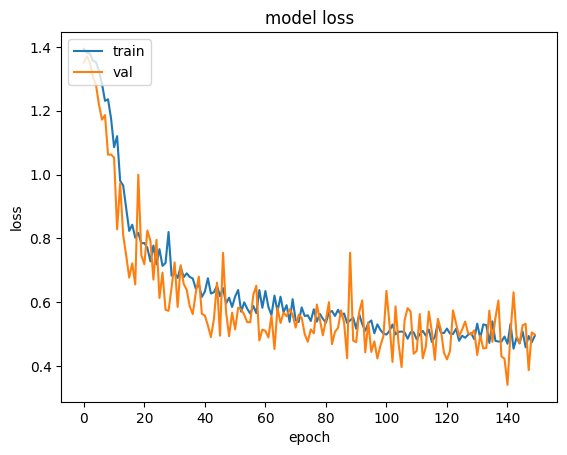

In [7]:
plt.plot(crnn_model_history.history['loss'])
plt.plot(crnn_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

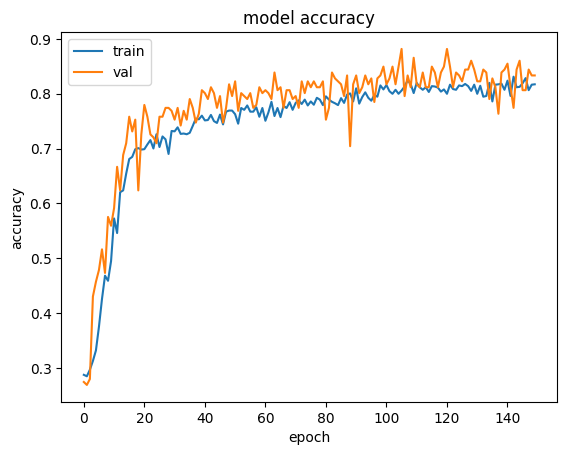

In [8]:
plt.plot(crnn_model_history.history['accuracy'])
plt.plot(crnn_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# trying to plot feature maps


In [73]:
def test_model():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3,3), padding='same',input_shape=(128,128)+(3,)))  # X_train.shape[1] = No. of Columns
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,5)))
    model.add(Conv2D(128,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(128,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(128,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    model.add(Conv2D(264,kernel_size=(1,1),padding='same'))
    model.add(LayerNormalization())
    model.add(Activation('leaky_relu'))
    model.add(MaxPooling2D(pool_size=(1,2)))
    
    # converting 2d data to 1d format for Bidirectional GRU
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model.add(Reshape((-1, 128)))
    model.add(Reshape((-1,128)))
    # bidirectional GRU
    
    model.add(Bidirectional(GRU(128, activation='tanh', dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation='tanh', dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    
    #FNN layer
    #model.add(TimeDistributed(Dense(128)))
#     model.add(LeakyReLU(alpha=0.05))
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    #model.add(TimeDistributed(Dense(4, activation='softmax')))
    
    return model

test_model().summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 layer_normalization_105 (La  (None, 128, 128, 64)     128       
 yerNormalization)                                               
                                                                 
 activation_105 (Activation)  (None, 128, 128, 64)     0         
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 128, 25, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 128, 25, 128)      8320      
                                                                 
 layer_normalization_106 (La  (None, 128, 25, 128)   

In [75]:
test_model = test_model()

In [76]:
from keras.utils import plot_model
plot_model(test_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [77]:
for i in range(len(test_model.layers)):
	# check for convolutional layer
	if 'conv' not in test_model.layers[i].name:
		continue
	# get filter weights
	filters, biases = test_model.layers[i].get_weights()
	print("layer number",i,test_model.layers[i].name, filters.shape)

layer number 0 conv2d_110 (3, 3, 3, 64)
layer number 4 conv2d_111 (1, 1, 64, 128)
layer number 8 conv2d_112 (1, 1, 128, 128)
layer number 12 conv2d_113 (1, 1, 128, 128)
layer number 16 conv2d_114 (1, 1, 128, 264)


In [81]:
# retrieve weights from the second hidden layer
filters , bias = test_model.layers[0].get_weights()

In [82]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [83]:
 # Get number of filters and their dimensions
num_filters = filters.shape[-1]
filter_size = filters.shape[0]
print(num_filters,filter_size)

64 3


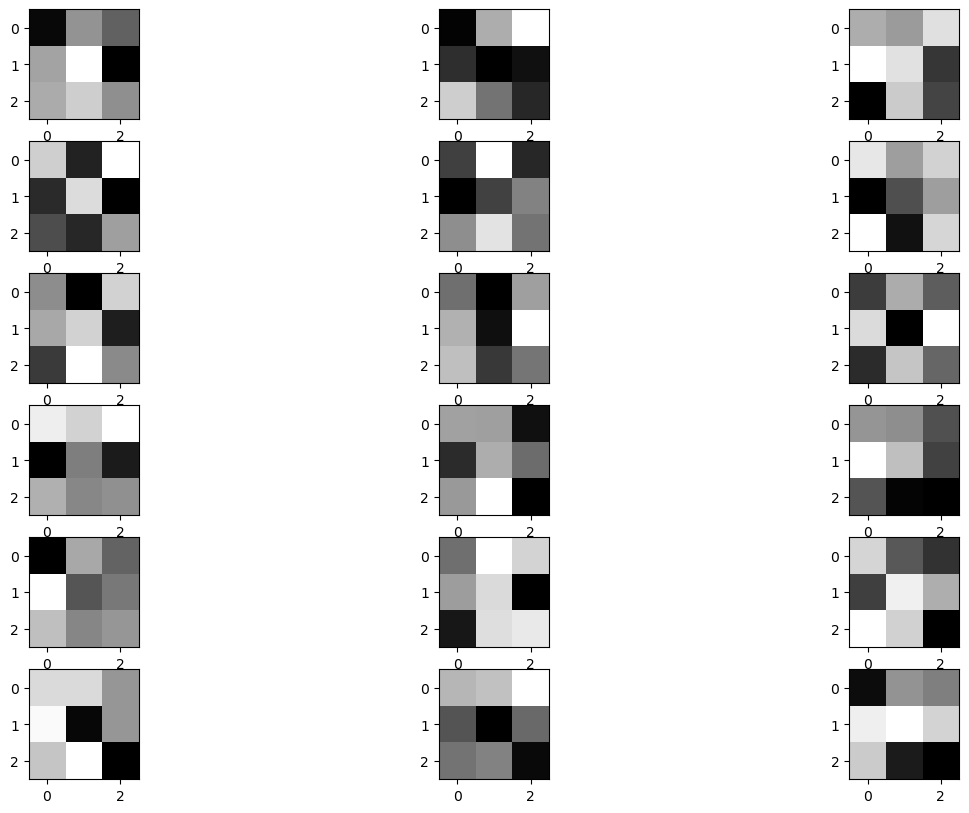

In [84]:
import matplotlib
import matplotlib.pyplot as plt

n_filters =6
ix=1
fig = plt.figure(figsize=(15,10))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

# testing with crnn model with an input image

In [86]:
from tensorflow.keras.models import Model
model = Model(inputs=crnn_model.inputs , outputs=crnn_model.layers[1].output)

In [93]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
image_path = "C:\\Users\\PC\\Desktop\\lisnen_segmented_working_data\\Melspectrograms\\Door_Bell_Melspectrorams\\doorbell_audio-1.png"
image = load_img(image_path , target_size=(128,128))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

#image = preprocess_input(image)

1/1 [==============================] - 0s 63ms/step


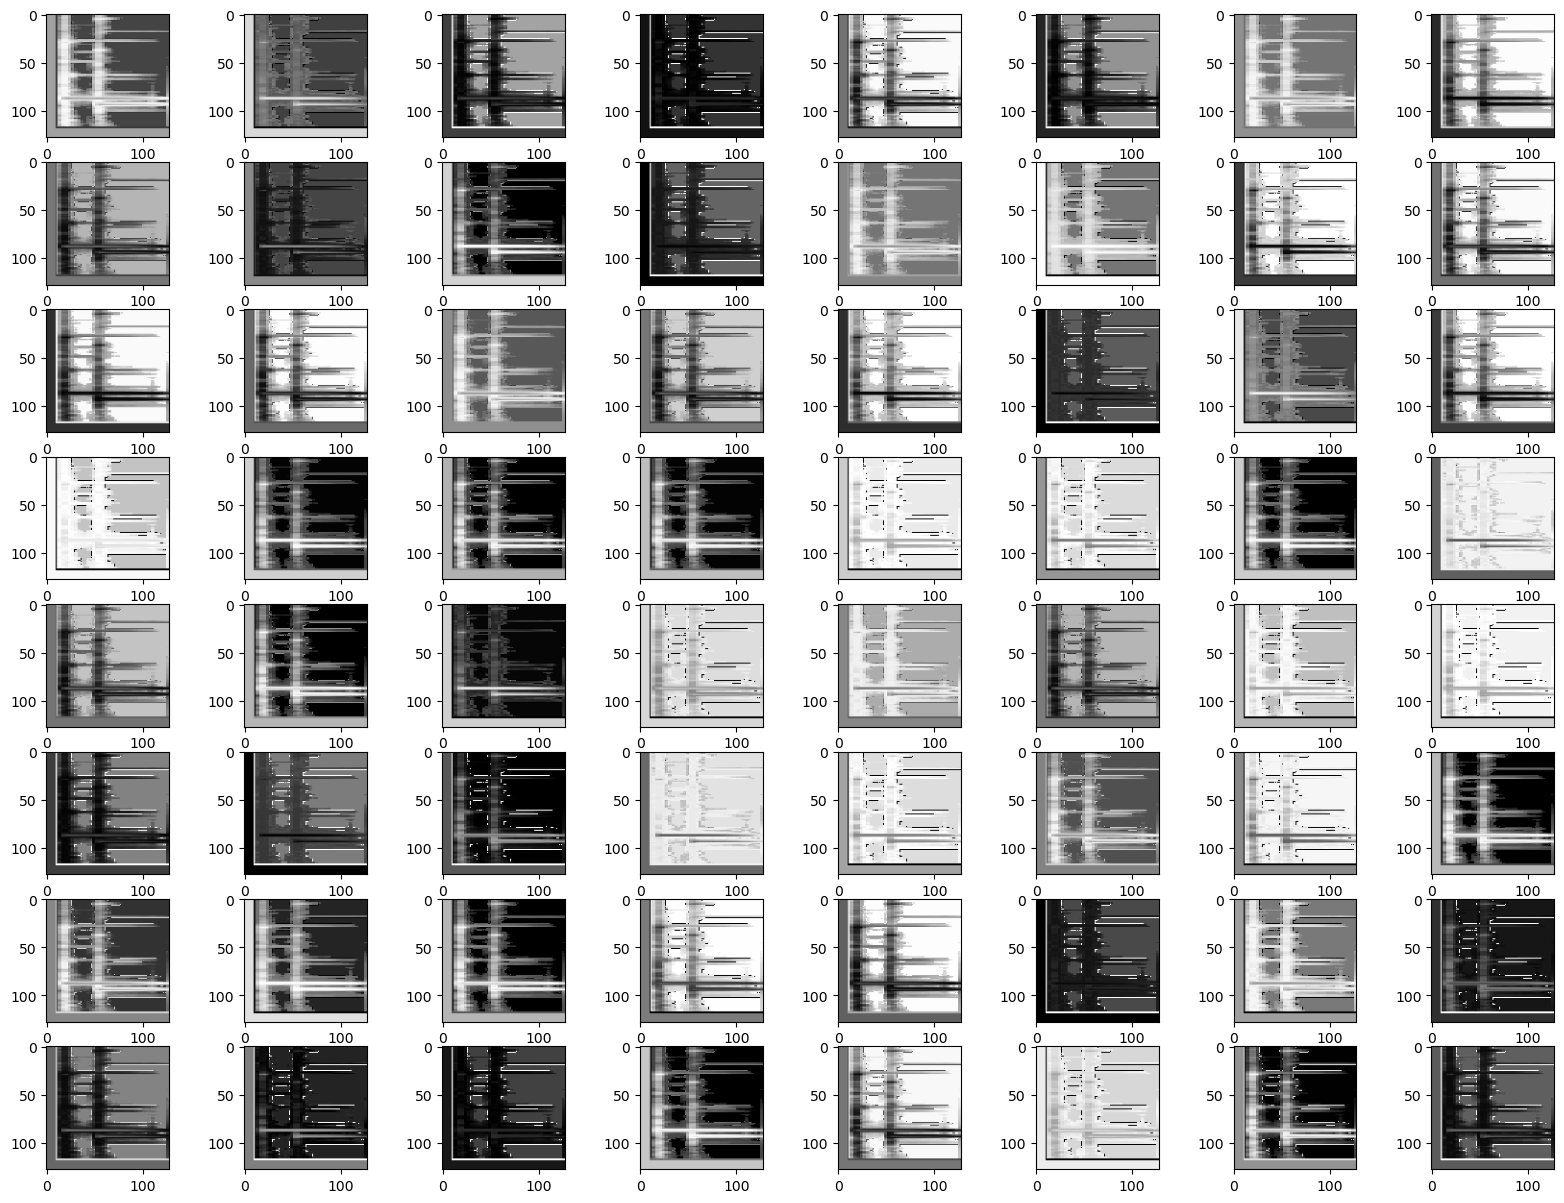

In [95]:
#calculating features_map
features = model.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

In [96]:
layer_index = [ 4, 8 , 12 , 16 ]
outputs = [model.layers[i].output for i in layer_index]

model3 = Model( inputs= model.inputs, outputs = outputs)
feature_map = model3.predict(image)

for i,fmap in zip(layer_index,feature_map):
    fig = pyplot.figure(figsize=(20,15))
    fig.suptitle("Layer_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        pyplot.subplot(8,8,i)
        pyplot.imshow(fmap[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

IndexError: list index out of range